# Flow control: Using `if` conditions


## Introduction

This tutorial provides a step-by-step guide on how to implement conditional logic in WorkGraph using two distinct methods:

1. **If**
2. **graph_builder Decorator**

## Using the `If`

WorkGraph provides the `If` context manager that allows you to define conditional logic in your workflow. The `If` block encapsulates all its child tasks, which are executed based on the defined conditions.

### Example

Suppose you have the following Python workflow:

In [2]:
def add(x, y):
    return x + y

def multiply(x, y):
    return x*y

# step 1
result = add(1, 1)                    # First addition
# step 2
if result < 0:
    result = add(result, 2)           # Conditionally execute addition
else:
    result = multiply(result, 2)      # Or multiplication
# step 3
result = add(result, 1)               # Last addition

print("Result is", result)

Result is 5


To convert this workflow into a WorkGraph, we first convert the Python functions, `add` and `multiply` to WG tasks, as
usual:


In [3]:
from aiida_workgraph import task

@task.calcfunction
def add(x, y):
    return x + y

@task.calcfunction
def multiply(x, y):
    return x*y



To then define define the conditional logic for the workflow, we use the `If` context manager provided by
AiiDA WorkGraph.
Using a context manager for the `If` also requires the `WorkGraph` itself being constructed as a context
manager: 
<!-- PRCOMMENT: Why? Still don't understand this... -->


In [ ]:
from aiida_workgraph import WorkGraph, If

with WorkGraph("if_task") as wg:
    result = add(x=1, y=1)
    # condition = compare(result, 0)
    # with If(condition):
    # with If(condition):
    #     wg.ctx.result = add(x=result, y=2)
    # with Else(condition):
    #     wg.ctx.result = multiply(x=result, y=2)
    with If(result < 0):
        wg.ctx.result = add(x=result, y=2)
    with If(result >= 0):
        wg.ctx.result = multiply(x=result, y=2)
    #---------------------------------------------------------------------
    result = add(name="add2", x=wg.ctx.result, y=1)

    # export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
wg

# PRCOMMENT

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'if_task…

In the GUI, two boxes, or **Zone**s are being shown, one for each branch as defined by the `If`, where each **If Zone**
has a `conditions` socket, and their `result`s are fed into the `select` **Zone**. 

### Submit the WorkGraph and check the results


In [12]:
from aiida import load_profile

load_profile()

wg.run()
print(f"State of WorkGraph: {wg.state}")
print(f'Result:             {result.value}')

07/07/2025 01:09:35 PM <177695> aiida.broker.rabbitmq: [WARNING] RabbitMQ v3.9.27 is not supported and will cause unexpected problems!
07/07/2025 01:09:35 PM <177695> aiida.broker.rabbitmq: [WARNING] It can cause long-running workflows to crash and jobs to be submitted multiple times.
07/07/2025 01:09:35 PM <177695> aiida.broker.rabbitmq: [WARNING] See https://github.com/aiidateam/aiida-core/wiki/RabbitMQ-version-to-use for details.
07/07/2025 01:09:37 PM <177695> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [113|WorkGraphEngine|continue_workgraph]: tasks ready to run: add,add2
07/07/2025 01:09:37 PM <177695> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [113|WorkGraphEngine|update_task_state]: Task: add, type: CALCFUNCTION, finished.
07/07/2025 01:09:37 PM <177695> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [113|WorkGraphEngine|continue_workgraph]: tasks ready to run: op_lt,op_ge,add2
07/07/2025 01:09:38 PM <177695> ai

State of WorkGraph: FINISHED
Result: uuid: 2295af5f-f7db-4086-b334-89a131f72d1f (pk: 131) value: 5


Finally, after the WG has finished, we generate the node (provenance) graph from the AiiDA process, where we can see
that the result of the `op_lt` (larger than) comparison is `False`, while for the `og_ge` (greater or equal) comparison
it is `True`, meaning that the branch with the intermediate multiplication was executed. 


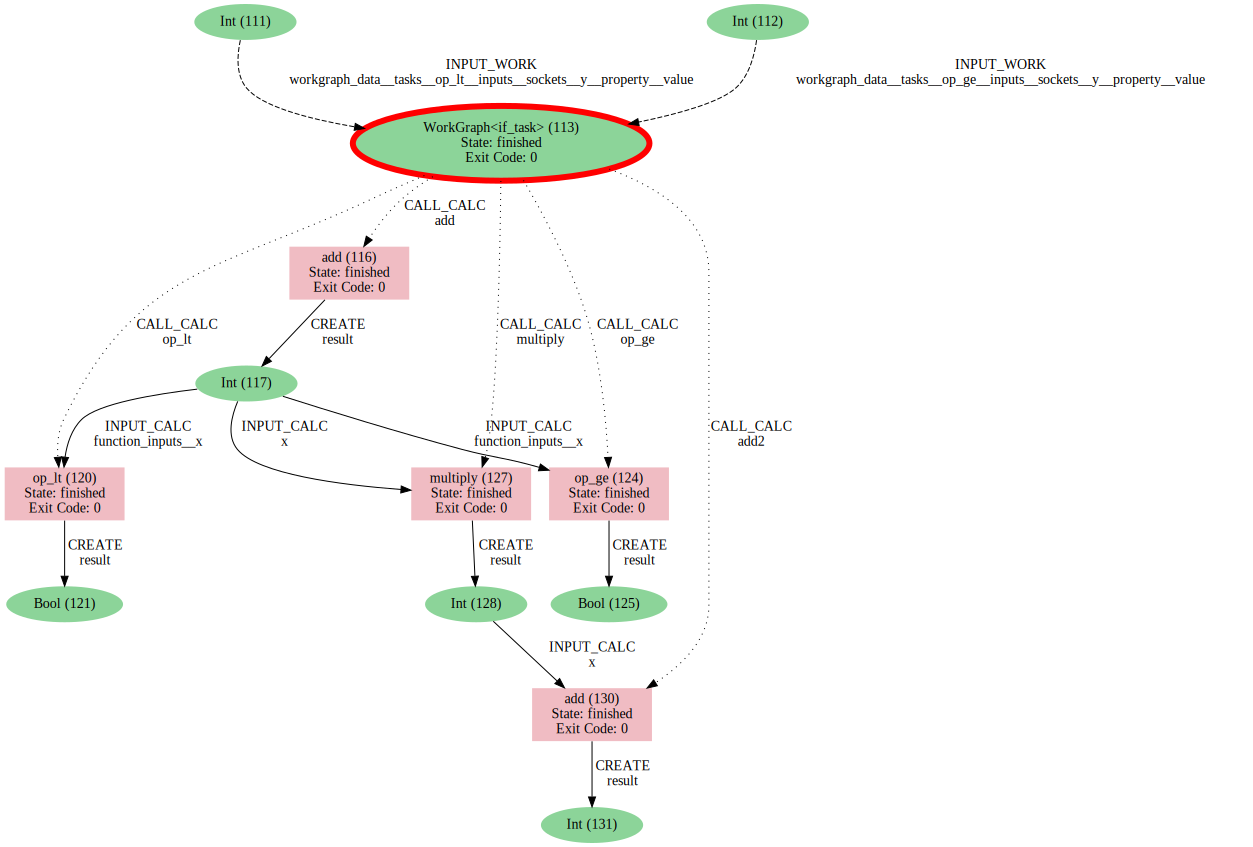

In [13]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Using the graph_builder Decorator

The `graph_builder` decorator is used for creating a dynamic `WorkGraph` during runtime based on input values (see [this
section](https://aiida-workgraph.readthedocs.io/en/latest/howto/autogen/graph_builder.html)).
<!-- How to link section in docs here locally? -->
This method differs significantly from the `If`:

- **Visibility**: In the GUI, only the `graph_builder` task is visible before execution, while for the `If`,
  both branches were shown
- **Dynamic Generation**: Upon running, it generates the WorkGraph dynamically, allowing for complex conditional logic and flow adjustments based on runtime data.


In [ ]:
# Create a WorkGraph which is dynamically generated based on the input
# then we output the result from the context
@task.graph_builder(outputs = [{"name": "result", "from": "ctx.data"}])
def add_multiply_if(x, y):
    wg = WorkGraph()
    if x.value > 0:
        add1 = wg.add_task(add, name="add1", x=x, y=y)
        # export the result of add1 to the context.data
        wg.ctx.data = add1.outputs.result
    else:
        multiply1 = wg.add_task(multiply, name="multiply1", x=x, y=y)
        # export the result of multiply1 to the context.dadta
        wg.ctx.data = multiply1.outputs.result
    return wg

### Create the workflow


In [ ]:
from aiida_workgraph import WorkGraph

wg = WorkGraph("if_graph_builer")
add1 = wg.add_task(add, name="add1", x=1, y=1)
add_multiply_if1 = wg.add_task(add_multiply_if, name="add_multiply_if1", x=add1.outputs.result, y=2)
add1 = wg.add_task(add, name="add2", x=add_multiply_if1.outputs.result, y=1)
# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg

In the GUI, we only see the `add_multiply_if1` task. When this task run, it will generate a `WorkGraph` based on the input value. This is different from the `If` task, in which we see all tasks before the WorkGraph run.


### Submit the WorkGraph and check the results


In [ ]:
wg.run()
print("State of WorkGraph         : {}".format(wg.state))
print('Result                     : {}'.format(wg.tasks.add2.outputs.result.value))

Generate node graph from the AiiDA process,and we can see that the `multiply` task is executed.

In [ ]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## If Task

Internally, the `if_` instruction is implemented using the `If` `Task` from the WorkGraph library.
In the WorkGraph user interface, the `If` `Task` is visually represented as an "If Zone".
This zone encapsulates all its child tasks, which are executed based on the defined conditions.

- **Conditions**: The If Zone includes a `conditions` socket, which determines when the tasks inside the zone should be executed.
- **Invert_condition**: If this input is True, it will invert the conditions.
- **Task Linking**: Tasks located outside the If Zone can be directly linked to tasks within the zone, allowing for dynamic workflow adjustments based on conditional outcomes.

Here is an example of how to add an `If` `Task` to a WorkGraph:

```python
if_task = wg.add_task(
   "If",
   name="if_false",
   conditions=condition1.outputs["result"],
   invert_condition=True
)
```

### Adding tasks to the If Zone
We can add tasks to the `If` zone using the `children` attribute.

```python
# add task1 and task2 to the if zone
if_task.children.add(["task1", "task2"])
```

### Creating the workflow
To construct the workflow, we'll utilize the built-in `If` and `Select` tasks from the Workgraph library. The `Select` task enables us to choose between two data sources based on a specified condition.

The `Select task has the following inputs:

   - **condition**: Provide the condition that dictates the selection between `true` and `false` outputs.
   - **true**: Specify the output to be used if the condition evaluates to `true`. 
   - **false**: Define the output for when the condition evaluates to `false`.


In [ ]:
from aiida_workgraph import WorkGraph

with WorkGraph("if_task") as wg:
    condition = add(x=1, y=1)
    if_true_zone = wg.add_task("workgraph.if_zone", name="if_true", conditions=condition)
    add2 = if_true_zone.add_task(add, name="add2", x=condition, y=2)
    if_false_zone = wg.add_task("workgraph.if_zone", name="if_false", conditions=condition, invert_condition=True)
    multiply1 = if_false_zone.add_task(multiply, name="multiply1", x=condition, y=2)
    # ---------------------------------------------------------------------
    select1 = wg.add_task(
        "workgraph.select",
        name="select1",
        true=add2.outputs["result"],
        false=multiply1.outputs["result"],
        condition=condition,
    )
    add3 = wg.add_task(add, name="add3", x=select1.outputs["result"], y=1)
# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg

### Summary

The `If` provides a visual and structured approach to managing conditional tasks within a defined zone. In contrast, the `graph_builder` decorator offers flexibility by dynamically generating the workflow based on runtime inputs, suitable for complex and adaptive process flows.
